## Определение перспективного тарифа для телеком компании

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описания тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:

1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута);

2. сообщение: 3 рубля;

3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:

1. минута разговора: 1 рубль;

2. сообщение: 1 рубль;

3. 1 Гб интернет-трафика: 150 рублей.

_Примечание:_

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

**Таблица `users` (информация о пользователях):**

`user_id` — уникальный идентификатор пользователя

`first_name` — имя пользователя

`last_name` — фамилия пользователя

`age` — возраст пользователя (годы)

`reg_date` — дата подключения тарифа (день, месяц, год)

`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

`city` — город проживания пользователя

`tarif` — название тарифного плана

----

**Таблица `calls` (информация о звонках):**

`id` — уникальный номер звонка

`call_date` — дата звонка

`duration` — длительность звонка в минутах

`user_id` — идентификатор пользователя, сделавшего звонок

----

**Таблица `messages` (информация о сообщениях):**

`id` — уникальный номер сообщения

`message_date` — дата сообщения

`user_id` — идентификатор пользователя, отправившего сообщение

----

**Таблица `internet` (информация об интернет-сессиях):**

`id` — уникальный номер сессии

`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)

`session_date` — дата интернет-сессии

`user_id` — идентификатор пользователя

----

**Таблица `tariffs` (информация о тарифах):**

`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


-----
<br>

_Примечание._

Если объединение таблиц командой `merge` приводит к ошибке `dead kernell`, примените `join`.

### Шаг 1. Откройте файлы с данными и изучите общую информацию

In [101]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

users = pd.read_csv('...')
calls = pd.read_csv('...')
messages = pd.read_csv('...')
internet = pd.read_csv('...')
tariffs = pd.read_csv('...')

Изучим общую информацию по набору данных `users`:

In [102]:
display(users.head())
display(users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

Здесь можно обратить внимание на то, что:

- как и было заявлено, данные предоставлены по `500` пользователям;

- идентификатор пользователя задаётся целочисленным типом данных `int64`;

- только по `38` пользователям известно о прекращении использования ими того или иного тарифа;

- не исключено, что здесь могут оказаться ситуации с 2 и более записями для одного и того же `user_id`, если некоторый пользователь переходил с одного тарифа на другой один или более раз;

- поля `reg_date` и `churn_date` будут нуждаться в приведении к типу `datetime`;

- хоть это и очевидно, но поле `age` можно будет переименовать для указания в его имени единиц измерения возраста (годы).

Теперь рассмотрим набор данных `calls`:

In [103]:
display(calls.head())
display(calls.info())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

Здесь сразу бросаются в глаза следующие моменты:

- интересный формат хранения идентификаторов звонков в формате разделения подчёркиванием идентификатора пользователя `user_id` и порядкового номера звонка, таким образом поле приобрело строковый тип (`object`);

- в данной таблице нет ни одного пропуска, данные предоставлены аж по `202607` звонкам;

- поля `duration` и `user_id` имеют корректные типы, `float64` и `int64` соответственно, а вот столбец `call_date`, судя по всему, нуждается в приведении к типу данных `datetime`;

- поле `duration` имеет смысл переименовать, чтобы по его названию было понятно в каких единицах измеряется длительность вызовов (минуты).

Далее проанализируем данные в таблице `messages`:

In [104]:
display(messages.head())
display(messages.info())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

Здесь всё очень схоже с предыдущей таблицей:

- нет ни одного пропуска при данных о `123036` сообщениях;

- формат содержимого поля `id` имеет ту же строковую структуру, состоящую из идентификатора пользователя и порядкового номера сообщения, разделённых между собой подчёркиванием;

- столбец `message_date` нуждается в преобразовании к типу `datetime`.

Переходим к следующей таблице - `internet`:

In [105]:
display(internet.head())
display(internet.info())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,1052.810,2018-09-07,1000
2,2,1000_2,1197.260,2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

Опять же, много сходств с предыдущей таблицей, но есть и новые моменты:

- столбец `Unnamed: 0`, судя по всему, задаёт номер записи в таблице и выглядит избыточным, вероятно от него потребуется избавиться далее;

- `id`, `user_id` и `session_date` аналогичны таким же полям из прошлой таблицы `messages`;

- столбец `session_date` потребуется преобразовать к типу `datetime`;

- пропуски отсутствуют, есть информация о `149396` интернет-сессиях.

Наконец, переходим к последнему набору данных - `tariffs`:

In [106]:
display(tariffs.head())
display(tariffs.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

Крошечная таблица всего из 2 строк, которая содержит информацию по каждому из двух тарифов исследования. Все поля целочисленные кроме строкового поля с именем тарифа `tariff_name`.

Возможно, имеет смысл соединить вместе таблицы `tariffs` и `users` по полю с именем тарифа, сделаем это в следующем разделе.

### Шаг 2. Подготовьте данные

Начнём с объёдинения таблиц `users` и `tariffs`, указывая имена полей для каждой из таблиц, поскольку поля с именем тарифа называются по-разному в этих двух таблицах:

In [107]:
users = users.merge(tariffs, left_on='tariff', right_on='tariff_name')
users.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,ultra


- Приведите данные к нужным типам;

In [108]:
# Переименовываем столбцы
users = users.rename(columns={'age': 'age_in_years'})
calls = calls.rename(columns={'duration': 'duration_in_mins'})

# Поскольку нужно привести к типу `datetime` сразу несколько полей, сделаем это с помощью функции
def convert_to_datetime(df, column, dt_format):
    '''Конвертирует поле `column` в таблице `df` в соответствии с форматом `dt_format`
    '''
    df[column] = pd.to_datetime(df[column], format=dt_format)

DT_FORMAT = '%Y-%m-%d'

# Приводим столбцы с датой к типу 'datetime'
convert_to_datetime(users, 'reg_date', DT_FORMAT)
convert_to_datetime(users, 'churn_date', DT_FORMAT)
convert_to_datetime(calls, 'call_date', DT_FORMAT)
convert_to_datetime(messages, 'message_date', DT_FORMAT)
convert_to_datetime(internet, 'session_date', DT_FORMAT)

- Найдите и исправьте ошибки в данных, если они есть.


Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Проверим, есть ли полные дубликаты и дубликаты по полю `user_id` в таблице `users`, а также проверим полные дубликаты и по остальным таблицам:

In [109]:
def is_containing_full_duplicates(df):
    '''Возвращает булев флаг о том, есть ли полные дубли в датафрейме `df`
    '''
    return False if df[df.duplicated()].shape[0] == 0 else True

print(f'Есть полные дубликаты в таблице "users"        : {is_containing_full_duplicates(users)}')
print(f'Есть полные дубликаты в таблице "calls"        : {is_containing_full_duplicates(calls)}')
print(f'Есть полные дубликаты в таблице "messages"     : {is_containing_full_duplicates(messages)}')
print(f'Есть полные дубликаты в таблице "internet"     : {is_containing_full_duplicates(internet)}')
print()
print('Есть дубли по полю "user_id" в таблице "users" :', users[users['user_id'].duplicated()].shape[0] != 0)

Есть полные дубликаты в таблице "users"        : False
Есть полные дубликаты в таблице "calls"        : False
Есть полные дубликаты в таблице "messages"     : False
Есть полные дубликаты в таблице "internet"     : False

Есть дубли по полю "user_id" в таблице "users" : False


Дубликатов нет, теперь проверим конец таблицы `internet` на предмет того, является ли столбец `Unnamed: 0` порядовым номером строки:

In [110]:
internet.tail()

,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.900,2018-10-03,1499
149392,149392,1499_153,490.130,2018-12-14,1499
149393,149393,1499_154,0.000,2018-10-27,1499
149394,149394,1499_155,1246.320,2018-11-26,1499
149395,149395,1499_156,544.370,2018-10-26,1499


Судя по выводу, так оно и есть, и данный столбец `Unnamed: 0` можно считать излишним. Удалим его из таблицы `internet`:

In [111]:
internet = internet.drop('Unnamed: 0', axis=1)
internet.tail()

,id,mb_used,session_date,user_id
149391,1499_152,318.900,2018-10-03,1499
149392,1499_153,490.130,2018-12-14,1499
149393,1499_154,0.000,2018-10-27,1499
149394,1499_155,1246.320,2018-11-26,1499
149395,1499_156,544.370,2018-10-26,1499


Теперь для выявления потенциальных ошибок проанализируем содержимое таблицы `users`: уникальные значения категориальных стобцов (чтобы убедиться, что там действительно люди с именем/фамилией и существующим городом):

In [112]:
print('-' * 50)
print('Города:')
print('-' * 50)
display(users['city'].sort_values().unique())
print('-' * 50)
print('Имена (начило и конец отсортированного списка):')
print('-' * 50)
display(users['first_name'].sort_values().unique()[:10])
display(users['first_name'].sort_values().unique()[-10:])
print('-' * 50)
print('Фамилии (начало и конец отсортированного списка):')
print('-' * 50)
display(users['last_name'].sort_values().unique()[:10])
display(users['last_name'].sort_values().unique()[-10:])

--------------------------------------------------
Города:
--------------------------------------------------


array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

--------------------------------------------------
Имена (начило и конец отсортированного списка):
--------------------------------------------------


array(['Авксентий', 'Агата', 'Агафья', 'Агнесса', 'Адам', 'Аким', 'Аксён',
       'Алан', 'Алевтина', 'Александр'], dtype=object)

array(['Эльмира', 'Эмилия', 'Эсмеральда', 'Юзефа', 'Юлий', 'Юлия', 'Юна',
       'Юрий', 'Яков', 'Яна'], dtype=object)

--------------------------------------------------
Фамилии (начало и конец отсортированного списка):
--------------------------------------------------


array(['Ёлчина', 'Ёркин', 'Ёркина', 'Ёрохов', 'Ёрохова', 'Абаимов',
       'Абакумов', 'Абакшина', 'Абалакова', 'Абалдуева'], dtype=object)

array(['Чистякова', 'Чумаков', 'Шарапов', 'Шарапова', 'Шарова', 'Швецов',
       'Шевцов', 'Шевцова', 'Щербакова', 'Яшина'], dtype=object)

Также рассмотрим характеристику распределения возраста в таблице `users`:

In [113]:
users[['age_in_years', 'user_id']].describe()

,age_in_years,user_id
count,500.000,500.000
mean,46.588,1249.500
std,16.668,144.482
min,18.000,1000.000
25%,32.000,1124.750
50%,46.000,1249.500
75%,62.000,1374.250
max,75.000,1499.000


Ничего, что вызывало бы подозрения на ошибочность: в столбце `age_in_years` минимум и максимум адекватные, а медиана почти равна среднему. В столбце `user_id` стоит обратить внимание на минимальное и максимальное значения - `1000` и `1499` соотвественно - они как раз соответствуют 500 пользователям, данные по которым были предоставлены.

Переходим к таблице `calls`, там оценим распределения для столбцов `duration_in_mins` и `user_id`:

In [114]:
calls.describe()

,duration_in_mins,user_id
count,202607.000,202607.000
mean,6.756,1253.941
std,5.843,144.723
min,0.000,1000.000
25%,1.300,1126.000
50%,6.000,1260.000
75%,10.700,1379.000
max,38.000,1499.000


В столбце `duration_in_mins` не обращаем внимание на минимальное значение в `0` минут (ими обозначены пропущенные звонки), максимум же соответствует `38` минутам (не самый длинный телефонный разговор, который можно представить, но раз мы имеем дело только с выборкой из 500 человек, можно предположить, что там не оказалось более разговорчивых людей). В `user_id`  всё выглядит адекватно, судя по минимальному и максимальному значениям.

Переходим к таблице `messages`:

In [115]:
messages.describe()

,user_id
count,123036.000
mean,1256.989
std,143.524
min,1000.000
25%,1134.000
50%,1271.000
75%,1381.000
max,1499.000


Минимальное и максимальное значения для `user_id` снова выглядят корректно, поэтому переходим к последней таблице - `internet`:

In [116]:
internet.describe()

,mb_used,user_id
count,149396.000,149396.000
mean,370.192,1252.100
std,278.301,144.051
min,0.000,1000.000
25%,138.188,1130.000
50%,348.015,1251.000
75%,559.553,1380.000
max,1724.830,1499.000


И тут `user_id` в порядке; что касается потреблённого трафика в рамках сессий, то здесь может насторожить только минимум в `0` Мб. Оценим, сколько имеется таких записей:

In [117]:
print(f"Записей с нулевым трафиком : {internet[internet['mb_used'] == 0].shape[0]}")
print(f"Всего записей              : {internet.shape[0]}")

Записей с нулевым трафиком : 19598
Всего записей              : 149396


Можно видеть, что записей довольно много, больше `10%`.

Попытаемся понять что-то об их характере, для чего выведем для некоторого конкретного пользователя его интернет-сессии за начало некоторого месяца (первые 7 дней ноября 2018 года):

In [118]:
internet[(internet['id'].str.startswith('1003_')) &
         (internet['session_date'].dt.month == 11) & 
         (internet['session_date'].dt.day <= 7)]

,id,mb_used,session_date,user_id
680,1003_4,370.890,2018-11-07,1003
683,1003_7,0.000,2018-11-04,1003
696,1003_20,314.270,2018-11-03,1003
707,1003_31,329.020,2018-11-06,1003


Глядя на результат выше, можно сделать такие два наблюдения:

- нулевой трафик не связан с началом либо с концом месяца (так что можно отсечь предположение о том, что нулевой трафик располагается в именно начале месяца и представляет собой потребление входящего в абонентскую плату объёма гигабайт);


- индексы сессий, идущие в поле `id` после идентификатора пользователя и подчёркивания, назначались сессиям в произвольном порядке (так сессия от 3 ноября имеет индекс `20`, а сессия за 4 ноября - индекс `7`).

Выведем количество пользователей из наших `500`, которые имеют нулевой трафик:

In [119]:
print(f"""Пользователей, для которых есть запись с нулевым трафиком:
        {internet[internet['mb_used'] == 0]['user_id'].unique().shape[0]}""")

Пользователей, для которых есть запись с нулевым трафиком:
        494


Как видно, нулевой трафик затрагивает по сути всех пользователей, данные по которым были предоставлены.

Выясним также объёмы самых маленьких с точки зрения трафика интернет-сессий:

In [120]:
internet.query('0 < mb_used < 0.08')

,id,mb_used,session_date,user_id
11027,1038_76,0.070,2018-12-30,1038
11399,1040_22,0.070,2018-11-23,1040
15944,1055_402,0.030,2018-06-15,1055
85722,1291_278,0.040,2018-08-10,1291
108198,1370_3,0.060,2018-07-18,1370


Из таблицы выше видно, что трафик самой маленькой зарегистрированной интернет-сессии составил всего `0.03 Mb`, что составляет примерно `30 Килобайт`. Это очень маленькое значение, и такое наблюдение ставит под сомнение гипотетическую идею о том, что все сессии с трафиком ниже определённого порога (скажем, `1 Мегабайт`) система расценивает как сессии с нулевым трафиком.

Можно было бы предположить, что сессии с нулевым трафиком как-то связаны с регистрацией телефона в сети 3G/4G и обменом по интернет-каналу какой-то служебной информацией, необходимой для регистрации телефона в сети. Такое могло бы происходить либо после включения телефона, либо в момент восстановления сигнала после его потери, скажем, где-то за городом или в цокольных помещениях.

Далее необходимо принять решение о том, как быть с такими интернет-сессиями: удалить их из нашего набора данных, попробовать заполнить их чем-то либо просто проигнорировать, оставив всё как есть. Судя по дальнейшему исследованию, нам потребуется вычислять помесячный суммарный трафик по каждому из пользователей, так что наличие интернет-сессий с нулевым трафиком нам не помешает, поскольку они не будут ничего превносить в получающуюся сумму. Таким образом, всё же оставим эти записи для таких интернет-сессий в нашей таблице.

Теперь сделаем округление звонков до следующей целой минуты (т.е. согласно правилу, что _«Мегалайн» всегда округляет секунды до минут_):

In [121]:
display(calls.head())
calls['duration_in_mins'] = np.ceil(calls['duration_in_mins']).astype(int)
display(calls.head())

,id,call_date,duration_in_mins,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


,id,call_date,duration_in_mins,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Начнём с создания вспомогательной таблицы `users_months`, которая будет иметь столбцами индексы месяцев, строками идентификаторы абонентов, а в ячейках будет содержать кортежи-пары из даты начала и даты конца соответствующего интервала:

In [122]:
max_month_index = 0

def add_delta_to_date(date, delta, add_seconds=False):
    """Добавляет период времени delta к дате, заданной в date"""
    date += delta
    if add_seconds:
        return pd.to_datetime(datetime(year=date.year, month=date.month, day=date.day, second=date.second))
    else:
        return pd.to_datetime(datetime(year=date.year, month=date.month, day=date.day))

def calculate_months_boundaries(row):
    """Формирует границы месяцев для пользователя, описанного строкой row
    
    Граница задаётся в виде интервала-кортежа (начальная_дата, конечная_дата)
    Для тех месяцев когда человек уже/ещё не являлся абонентом, соответствующее значение будет равно NaN
    
    Месяцы задаются в виде индексов, глобальной финальной датой считается "2018-12-31 23:59:59"

    Чтобы избежать пересечения соседних интервалов между собой, конечная точка
    интервала i (скажем, "2018-06-24 00:00:00") будет отличаться от начальной точки i+1 интервала
    на +1 секудку (т.е. "2018-06-24 00:00:01")

    Индексов месяцев может быть более 12: скажем, если пользователь подключился к оператору 1 ноября, то:
    - 11 месяц будет иметь интервал (2018-11-01 00:00:00, 2018-12-01 00:00:00)
    - 12 месяц будет иметь интервал (2018-12-01 00:00:01, 2018-12-31 00:00:00)
    Тогда при условии, что данный абонент не отключался от оператора в 2018 году, у нас будет присутствовать
    ещё один интервал длиной в одни сутки 31 декабря, т.е.
    - 13 месяц будет иметь интервал (2018-12-31 00:00:01, 2018-12-31 23:59:59)
    """
    last_date_2018 = pd.to_datetime(datetime(2018, 12, 31, 23, 59, 59))

    curr_date = row['reg_date']
    next_date = add_delta_to_date(curr_date, np.timedelta64(1, 'M'))
    month_index = curr_date.month

    while curr_date < next_date:
        if pd.isnull(row['churn_date']):
            if next_date.year == 2018:
                row.loc[month_index] = (curr_date, next_date)
            else:
                row.loc[month_index] = (curr_date, last_date_2018)
                break
        else:
            if next_date <= row['churn_date']:
                row.loc[month_index] = (curr_date, next_date)
            else:
                row.loc[month_index] = (curr_date, row['churn_date'])
                break
            
        curr_date = add_delta_to_date(next_date, np.timedelta64(1, 's'), add_seconds=True)
        next_date = add_delta_to_date(curr_date, np.timedelta64(1, 'M'))
        month_index += 1

    global max_month_index
    max_month_index = max(max_month_index, month_index)
    return row

users_months = users.apply(calculate_months_boundaries, axis=1)

MONTHS_INDICES_LIST = [i for i in range(1, max_month_index + 1)]

users_months = (users_months[['user_id', 'reg_date', 'churn_date'] + MONTHS_INDICES_LIST]
                        .sort_values(by='user_id'))

# Выведем некоторых характерных пользователей отдельно, чтобы убедиться в правильности работы функции
display(users_months[(users_months['user_id'] == 1000) |
                     (users_months['user_id'] == 1001) |
                     (users_months['user_id'] == 1008) |
                     (users_months['user_id'] == 1006) |
                     (users_months['user_id'] == 1018) |
                     (users_months['user_id'] == 1499) |
                     (users_months['user_id'] == 1438) |
                     (users_months['user_id'] == 1498)])

,user_id,reg_date,churn_date,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1000,2018-05-25,NaT,NaN,NaN,NaN,NaN,"(2018-05-25 00:00:00, 2018-06-24 00:00:00)","(2018-06-24 00:00:01, 2018-07-24 00:00:00)","(2018-07-24 00:00:01, 2018-08-23 00:00:00)","(2018-08-23 00:00:01, 2018-09-22 00:00:00)","(2018-09-22 00:00:01, 2018-10-22 00:00:00)","(2018-10-22 00:00:01, 2018-11-21 00:00:00)","(2018-11-21 00:00:01, 2018-12-21 00:00:00)","(2018-12-21 00:00:01, 2018-12-31 23:59:59)",NaN
149,1001,2018-11-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2018-11-01 00:00:00, 2018-12-01 00:00:00)","(2018-12-01 00:00:01, 2018-12-31 00:00:00)","(2018-12-31 00:00:01, 2018-12-31 23:59:59)"
152,1006,2018-02-26,NaT,NaN,"(2018-02-26 00:00:00, 2018-03-28 00:00:00)","(2018-03-28 00:00:01, 2018-04-27 00:00:00)","(2018-04-27 00:00:01, 2018-05-27 00:00:00)","(2018-05-27 00:00:01, 2018-06-26 00:00:00)","(2018-06-26 00:00:01, 2018-07-26 00:00:00)","(2018-07-26 00:00:01, 2018-08-25 00:00:00)","(2018-08-25 00:00:01, 2018-09-24 00:00:00)","(2018-09-24 00:00:01, 2018-10-24 00:00:00)","(2018-10-24 00:00:01, 2018-11-23 00:00:00)","(2018-11-23 00:00:01, 2018-12-23 00:00:00)","(2018-12-23 00:00:01, 2018-12-31 23:59:59)",NaN
154,1008,2018-12-19,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2018-12-19 00:00:00, 2018-12-31 23:59:59)",NaN
5,1018,2018-04-01,NaT,NaN,NaN,NaN,"(2018-04-01 00:00:00, 2018-05-01 00:00:00)","(2018-05-01 00:00:01, 2018-05-31 00:00:00)","(2018-05-31 00:00:01, 2018-06-30 00:00:00)","(2018-06-30 00:00:01, 2018-07-30 00:00:00)","(2018-07-30 00:00:01, 2018-08-29 00:00:00)","(2018-08-29 00:00:01, 2018-09-28 00:00:00)","(2018-09-28 00:00:01, 2018-10-28 00:00:00)","(2018-10-28 00:00:01, 2018-11-27 00:00:00)","(2018-11-27 00:00:01, 2018-12-27 00:00:00)","(2018-12-27 00:00:01, 2018-12-31 23:59:59)"
457,1438,2018-10-05,2018-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2018-10-05 00:00:00, 2018-11-04 00:00:00)","(2018-11-04 00:00:01, 2018-12-04 00:00:00)","(2018-12-04 00:00:01, 2018-12-24 00:00:00)",NaN
498,1498,2018-07-19,2018-10-25,NaN,NaN,NaN,NaN,NaN,NaN,"(2018-07-19 00:00:00, 2018-08-18 00:00:00)","(2018-08-18 00:00:01, 2018-09-17 00:00:00)","(2018-09-17 00:00:01, 2018-10-17 00:00:00)","(2018-10-17 00:00:01, 2018-10-25 00:00:00)",NaN,NaN,NaN
499,1499,2018-09-27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(2018-09-27 00:00:00, 2018-10-27 00:00:00)","(2018-10-27 00:00:01, 2018-11-26 00:00:00)","(2018-11-26 00:00:01, 2018-12-26 00:00:00)","(2018-12-26 00:00:01, 2018-12-31 23:59:59)",NaN


Теперь создадим вспомогательный датафрейм `users_interval_index`, для которого по идентификатору пользователя можно будет получить его месячные интервалы в виде индексированной структуры данных `pandas.IntervalIndex`:

In [123]:
def assign_index_of_bins_for_user(row):
    """Формирует индексированную структуру из месячных интервалов для пользователя, описанного строкой row"""
    intervals = list()
    dummy_interval = (pd.to_datetime(np.NaN), pd.to_datetime(np.NaN))
    
    for i in MONTHS_INDICES_LIST:
        interval = row[i]
        if pd.isnull(interval):
            intervals.append(dummy_interval)
        else:
            intervals.append(interval)

    interval_index = pd.IntervalIndex.from_tuples(intervals, closed='both')
    return interval_index

users_interval_index = users[['user_id']].sort_values(by='user_id')
users_interval_index['index_of_bins'] = users_months.apply(assign_index_of_bins_for_user, axis=1)

display(users_interval_index)

,user_id,index_of_bins
0,1000,"IntervalIndex([nan, nan, nan, nan, [2018-05-25..."
149,1001,"IntervalIndex([nan, nan, nan, nan, nan ... nan..."
150,1002,"IntervalIndex([nan, nan, nan, nan, nan ... [20..."
1,1003,"IntervalIndex([nan, nan, nan, nan, nan ... [20..."
2,1004,"IntervalIndex([nan, nan, nan, nan, [2018-05-14..."
...,...,...
148,1495,"IntervalIndex([nan, nan, nan, nan, nan ... [20..."
496,1496,"IntervalIndex([[2018-01-27, 2018-02-26], [2018..."
497,1497,"IntervalIndex([nan, nan, nan, nan, nan ... nan..."
498,1498,"IntervalIndex([nan, nan, nan, nan, nan ... [20..."


Теперь, пользуясь полученной на предыдущем шаге таблицей `users_interval_index`, обратимся к таблицам, хранящим информацию о сообщениях, звонках и выходах в интернет, и определим для каждой даты (сообщения, звонка или выхода в интернет) её целевую месячную корзину, т.е. индекс месяца, к которому относится дата.

Подсчитанную информацию о корзинах добавим отдельным столбцом в каждую из таблиц `messages` (столбец `message_bin`), `internet` (столбец `session_bin`) и `calls` (столбец `call_bin`):

In [124]:
def assign_bin_to_date(date, interval_index):
    """Определяет корзину с номером месяца для даты, переданной в параметре date
    Номер корзины определяется на основе вхождения даты в один из месячных интервалов,
    хранящихся в interval_index
    """
    interval_index_arr = np.where(interval_index.contains(date))[0]
        
    interval_index_from_0 = interval_index_arr[0]
    interval = interval_index[interval_index_from_0]
    
    if interval.length >= pd.Timedelta('29 days 23:59:59'):
        # Месяц был полный - возвращаем индекс целевого интервала для данной даты, например, "12"
        return interval_index_from_0 + 1
    else:
        # Месяц был неполный - возвращаем индекс целевого интервала с постфиксом "truncated",
        # например, "12-truncated"
        # Это нужно для того, чтобы впоследствии иметь возможность фильтровать и рассматривать
        # либо все месяцы, либо только полные
        return f'{interval_index_from_0 + 1}-truncated'
    
def assign_bins_to_users_activity_dates(row):
    """Для каждой из дат активностей (сообщение, звонок, выход в интернет) пользователя, которые
    перечислены в строке row, определяет её целевую месячную корзину (т.е. индекс того месяца,
    к которому относится дата данной активности)
    
    Возвращает Series с номерами целевых корзин"""
    activity_date = row
    user_id = row.name
    interval_index = users_interval_index.query('user_id == @user_id')['index_of_bins'].iloc[0]
    
    if len(interval_index.values) == 0:
        return np.NaN

    bins = activity_date.apply(assign_bin_to_date, interval_index=interval_index)
    return bins

messages['message_bin'] = (messages.groupby('user_id')['message_date']
                                   .transform(assign_bins_to_users_activity_dates))
display(messages)

internet['session_bin'] = (internet.groupby('user_id')['session_date']
                                   .transform(assign_bins_to_users_activity_dates))
display(internet)

calls['call_bin'] = (calls.groupby('user_id')['call_date']
                          .transform(assign_bins_to_users_activity_dates))
display(calls)

,id,message_date,user_id,message_bin
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,9
2,1000_2,2018-08-04,1000,7
3,1000_3,2018-06-16,1000,5
4,1000_4,2018-12-05,1000,11
...,...,...,...,...
123031,1499_179,2018-12-12,1499,11
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,10


,id,mb_used,session_date,user_id,session_bin
0,1000_0,112.950,2018-11-25,1000,11
1,1000_1,1052.810,2018-09-07,1000,8
2,1000_2,1197.260,2018-06-25,1000,6
3,1000_3,550.270,2018-08-22,1000,7
4,1000_4,302.560,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.900,2018-10-03,1499,9
149392,1499_153,490.130,2018-12-14,1499,11
149393,1499_154,0.000,2018-10-27,1499,9
149394,1499_155,1246.320,2018-11-26,1499,10


,id,call_date,duration_in_mins,user_id,call_bin
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,7
2,1000_2,2018-06-11,3,1000,5
3,1000_3,2018-09-21,14,1000,8
4,1000_4,2018-12-15,6,1000,11
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,11
202603,1499_216,2018-10-18,19,1499,9
202604,1499_217,2018-11-10,11,1499,10
202605,1499_218,2018-10-06,5,1499,9


Теперь для каждой их таблиц с сообщениями, интернет-сессиями и звонками создадим сводную таблицу, используя подсчитанные выше столбцы с корзинами (месячными индексами) в качестве столбцов, и идентификаторы пользователей в качестве индекса (строк). Что касается агрегирующих функций, то для интернет-сессий и звонков будем использовать "сумму" (по использованным мегабайтам трафика и минутам соответственно), а для сообщений - "количество". Для звонков также создадим отдельную сводную таблицу с агрегирующей функцией `count` для подсчёта количества сделанных звонков.

Результаты запишем в таблицы `messages_counts`, `internet_sums`, `calls_sums` и `calls_counts`.

Для суммарного количества сообщений и суммарных минут звонков сделаем приведение к целому (в случае минут округление по правилам оператора уже было сделано выше), а в случае интернет-трафика результаты пока оставим вещественными, поскольку округление до гигабайтов будет сделано ниже. Нулями заполним те месячные индексы, которые не содержали соответствующей активности пользователя (не было ни одного звонка, сообщения или выхода в интернет):

In [125]:
def create_pivot_table(table, column, value, aggfunc):
    return (table
                .pivot_table(index='user_id', columns=column, values=value, aggfunc=aggfunc)
                .rename_axis(None, axis=1)
                .reindex(users['user_id'], fill_value=np.NaN)
                .sort_values(by='user_id')
                .fillna(0)
                .reset_index())

print('Сообщения (количество):')
messages_counts = create_pivot_table(messages, 'message_bin', 'id', 'count').astype(int)
display(messages_counts)

print('Интернет (суммарный трафик, Мб, до округления):')
internet_sums = create_pivot_table(internet, 'session_bin', 'mb_used', 'sum')
display(internet_sums)

print('Звонки (суммарная длительность):')
calls_sums = create_pivot_table(calls, 'call_bin', 'duration_in_mins', 'sum').astype(int)
display(calls_sums)

print('Звонки (количество):')
calls_counts = create_pivot_table(calls, 'call_bin', 'duration_in_mins', 'count').astype(int)
display(calls_counts)

Сообщения (количество):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,10-truncated,11-truncated,12-truncated,13-truncated,8-truncated,9-truncated
0,1000,0,0,0,0,63,70,78,72,54,72,70,0,0,0,17,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,8,14,8,5,14,15,0,0,0,6,0,0,0
3,1003,0,0,0,0,0,0,0,81,95,79,87,0,0,0,38,0,0,0
4,1004,0,0,0,0,154,155,156,160,139,164,161,0,0,0,103,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,81,89,77,77,0,0,0,16,0,0,0
496,1496,50,46,48,41,36,36,41,33,34,37,49,0,0,0,17,0,0,0
497,1497,0,0,0,0,0,0,0,0,0,22,16,0,0,0,13,0,0,0
498,1498,0,0,0,0,0,0,53,49,57,0,0,0,9,0,0,0,0,0


Интернет (суммарный трафик, Мб, до округления):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,10-truncated,11-truncated,12-truncated,13-truncated,8-truncated,9-truncated
0,1000,0.000,0.000,0.000,0.000,17821.040,18727.600,11440.520,16078.190,16778.950,14800.290,8440.000,0.000,0.000,0.000,3305.720,0.000,0.000,0.000
1,1001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18429.340,14036.660,0.000,0.000,0.000,0.000,0.000,0.000
2,1002,0.000,0.000,0.000,0.000,0.000,20635.670,15548.920,20190.250,13633.610,16399.590,18806.330,0.000,0.000,0.000,10822.150,0.000,0.000,0.000
3,1003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11958.230,16425.590,15571.980,7219.890,0.000,0.000,0.000,6104.950,0.000,0.000,0.000
4,1004,0.000,0.000,0.000,0.000,20602.050,19906.940,24884.020,22760.540,18654.190,14992.210,15634.130,0.000,0.000,0.000,11605.400,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30357.990,27542.360,41866.610,22781.360,0.000,0.000,0.000,4862.240,0.000,0.000,0.000
496,1496,29162.650,24445.190,23986.670,21704.080,21767.330,21169.520,24049.380,24010.030,28569.440,28101.530,17683.760,0.000,0.000,0.000,6292.710,0.000,0.000,0.000
497,1497,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17254.730,14518.680,0.000,0.000,0.000,13801.560,0.000,0.000,0.000
498,1498,0.000,0.000,0.000,0.000,0.000,0.000,24181.540,19118.810,26069.650,0.000,0.000,0.000,5055.220,0.000,0.000,0.000,0.000,0.000


Звонки (суммарная длительность):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,10-truncated,11-truncated,12-truncated,13-truncated,8-truncated,9-truncated
0,1000,0,0,0,0,299,284,399,465,370,323,337,0,0,0,89,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,430,414,0,0,0,0,0,0
2,1002,0,0,0,0,0,220,262,213,205,204,315,0,0,0,98,0,0,0
3,1003,0,0,0,0,0,0,0,938,851,789,905,0,0,0,339,0,0,0
4,1004,0,0,0,0,92,154,141,147,80,173,87,0,0,0,113,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,856,963,899,1049,0,0,0,153,0,0,0
496,1496,611,527,526,460,549,539,584,463,458,681,379,0,0,0,207,0,0,0
497,1497,0,0,0,0,0,0,0,0,0,616,352,0,0,0,438,0,0,0
498,1498,0,0,0,0,0,0,394,467,314,0,0,0,118,0,0,0,0,0


Звонки (количество):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,10-truncated,11-truncated,12-truncated,13-truncated,8-truncated,9-truncated
0,1000,0,0,0,0,54,46,53,53,56,48,47,0,0,0,11,0,0,0
1,1001,0,0,0,0,0,0,0,0,0,0,59,63,0,0,0,0,0,0
2,1002,0,0,0,0,0,28,34,37,33,35,35,0,0,0,15,0,0,0
3,1003,0,0,0,0,0,0,0,135,108,104,120,0,0,0,53,0,0,0
4,1004,0,0,0,0,21,27,20,25,19,34,14,0,0,0,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,118,145,128,150,0,0,0,24,0,0,0
496,1496,78,76,69,59,75,64,94,66,72,84,64,0,0,0,27,0,0,0
497,1497,0,0,0,0,0,0,0,0,0,87,59,0,0,0,55,0,0,0
498,1498,0,0,0,0,0,0,50,68,47,0,0,0,15,0,0,0,0,0


Теперь из таблиц `messages_counts`, `internet_sums`, `calls_sums` и `calls_counts` выделим отдельные таблицы, которые будут покрывать только **полные месяцы**, т.е. рассматривая только те столбцы, которые не имеют постфикса `-truncated`.

Рассматривать только полные месяцы здесь будем для того, чтобы ответить на следующий вопрос:

_Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа **в месяц**?_

Эти таблицы будут иметь префикс `fm_` (от "_full month_"): `fm_messages_counts`, `fm_internet_sums`, `fm_calls_sums` и `fm_calls_counts`:

In [126]:
fm_messages_counts = messages_counts[['user_id'] + MONTHS_INDICES_LIST[:-1]]
fm_internet_sums = internet_sums[['user_id'] + MONTHS_INDICES_LIST[:-1]]
fm_calls_sums = calls_sums[['user_id'] + MONTHS_INDICES_LIST[:-1]]
fm_calls_counts = calls_counts[['user_id'] + MONTHS_INDICES_LIST[:-1]]

display(fm_messages_counts.head())
display(fm_internet_sums.head())
display(fm_calls_sums.head())
display(fm_calls_counts.head())

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,63,70,78,72,54,72,70,0
1,1001,0,0,0,0,0,0,0,0,0,0,0,0
2,1002,0,0,0,0,0,8,14,8,5,14,15,0
3,1003,0,0,0,0,0,0,0,81,95,79,87,0
4,1004,0,0,0,0,154,155,156,160,139,164,161,0


,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0.000,0.000,0.000,0.000,17821.040,18727.600,11440.520,16078.190,16778.950,14800.290,8440.000,0.000
1,1001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18429.340,14036.660
2,1002,0.000,0.000,0.000,0.000,0.000,20635.670,15548.920,20190.250,13633.610,16399.590,18806.330,0.000
3,1003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11958.230,16425.590,15571.980,7219.890,0.000
4,1004,0.000,0.000,0.000,0.000,20602.050,19906.940,24884.020,22760.540,18654.190,14992.210,15634.130,0.000


,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,299,284,399,465,370,323,337,0
1,1001,0,0,0,0,0,0,0,0,0,0,430,414
2,1002,0,0,0,0,0,220,262,213,205,204,315,0
3,1003,0,0,0,0,0,0,0,938,851,789,905,0
4,1004,0,0,0,0,92,154,141,147,80,173,87,0


,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,54,46,53,53,56,48,47,0
1,1001,0,0,0,0,0,0,0,0,0,0,59,63
2,1002,0,0,0,0,0,28,34,37,33,35,35,0
3,1003,0,0,0,0,0,0,0,135,108,104,120,0
4,1004,0,0,0,0,21,27,20,25,19,34,14,0


Наконец, выполним приведение интернет-трафика из мегабайтов к гигабайтам в соответствии с правилом:

"_Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта._"

In [127]:
def custom_convert_mb_to_gb(mb):
    """Конвертирует мегабайты в гигабайты с округлением в большую сторону"""
    MB_IN_GB = 1_024
    if (mb % MB_IN_GB) == 0:
        result = mb // MB_IN_GB
    else:
        result = (mb // MB_IN_GB) + 1
    return int(result)

print('Интернет (полные месяцы, суммарный трафик, Гб, после округления):')
fm_internet_sums = fm_internet_sums.set_index('user_id').applymap(custom_convert_mb_to_gb).reset_index()
display(fm_internet_sums.head())

Интернет (полные месяцы, суммарный трафик, Гб, после округления):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,18,19,12,16,17,15,9,0
1,1001,0,0,0,0,0,0,0,0,0,0,18,14
2,1002,0,0,0,0,0,21,16,20,14,17,19,0
3,1003,0,0,0,0,0,0,0,12,17,16,8,0
4,1004,0,0,0,0,21,20,25,23,19,15,16,0


Далее необходимо определить помесячную выручку с каждого пользователя, согласно следующей рекомендации:

_Вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану_

Здесь я предпринял попытку по возможности не использовать самостоятельно написанных циклов, а вместо этого подготовить вспомогательные матрицы и далее использовать матричные операции (сложение, вычитание, поэлементное умножение). Возможно, это привело к усложнению процесса вычисления требуемой помесячной выручки, но мне хотелось довести такое решиние до конца.

Начнём с того, что создадим вспомогательную матрицу-маску `fm_rub_monthly_fee_mask`, которая вся будет состоять из `0` и `1`. В ней на пересечении идентификатора пользователя и индекса месяца будет стоять `1`, если для данного пользователя ненулевым является соответствующий месячный интервал, и `0` в противном случае:

In [128]:
fm_rub_monthly_fee_mask = users_months[['user_id'] + MONTHS_INDICES_LIST[:-1]].copy()
fm_rub_monthly_fee_mask[MONTHS_INDICES_LIST[:-1]] = (fm_rub_monthly_fee_mask[MONTHS_INDICES_LIST[:-1]]
    .where(fm_rub_monthly_fee_mask.isna(), 1)
    .fillna(0))
fm_rub_monthly_fee_mask = fm_rub_monthly_fee_mask.reset_index(drop=True)

display(fm_rub_monthly_fee_mask)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,1,1,1,1,1,1,1,1
1,1001,0,0,0,0,0,0,0,0,0,0,1,1
2,1002,0,0,0,0,0,1,1,1,1,1,1,1
3,1003,0,0,0,0,0,0,0,1,1,1,1,1
4,1004,0,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,1,1,1,1,1
496,1496,1,1,1,1,1,1,1,1,1,1,1,1
497,1497,0,0,0,0,0,0,0,0,0,1,1,1
498,1498,0,0,0,0,0,0,1,1,1,1,0,0


Теперь создадим вспомогательные матрицы c размерами абонентской платы, стоимостями гигабайта интернета, сообщения и минуты разговора, а также количеством включенных в абонентскую плату:

- ... сообщений в месяц;

- ... минут разговора в месяц;

- ... гигабайтов интернет-трафика в месяц

Для создания таких таблиц будет размножим нужное количество раз (по количеству индексов месяцев) соответствующий столбец из таблицы `users`:

In [129]:
fm_rub_monthly_fee_df = fm_rub_monthly_fee_mask[['user_id']].copy()

fm_messages_included_df     = fm_rub_monthly_fee_df.copy()
fm_minutes_included_df      = fm_rub_monthly_fee_df.copy()
fm_gb_per_month_included_df = fm_rub_monthly_fee_df.copy()
fm_rub_per_gb_df            = fm_rub_monthly_fee_df.copy()
fm_rub_per_message_df       = fm_rub_monthly_fee_df.copy()
fm_rub_per_minute_df        = fm_rub_monthly_fee_df.copy()

users_sorted = users.sort_values(by='user_id').reset_index(drop=True)
for i in MONTHS_INDICES_LIST[:-1]:
    fm_rub_monthly_fee_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['rub_monthly_fee']
    fm_messages_included_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['messages_included']
    fm_minutes_included_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['minutes_included']
    fm_rub_per_gb_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['rub_per_gb']
    fm_rub_per_message_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['rub_per_message']
    fm_rub_per_minute_df.loc[:, i] = fm_rub_monthly_fee_mask[i] * users_sorted['rub_per_minute']

    gb_per_month = fm_rub_monthly_fee_mask[i] * users_sorted['mb_per_month_included']
    gb_per_month = gb_per_month.apply(custom_convert_mb_to_gb)
    fm_gb_per_month_included_df.loc[:, i] = gb_per_month

print('Абонентская плата по пользователям (₽):')
display(fm_rub_monthly_fee_df)

Абонентская плата по пользователям (₽):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1001,0,0,0,0,0,0,0,0,0,0,550,550
2,1002,0,0,0,0,0,550,550,550,550,550,550,550
3,1003,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
4,1004,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
496,1496,550,550,550,550,550,550,550,550,550,550,550,550
497,1497,0,0,0,0,0,0,0,0,0,550,550,550
498,1498,0,0,0,0,0,0,550,550,550,550,0,0


Для последующих матричных операций устанавливаем для таблиц ниже в качестве индекса поле `user_id`:

In [130]:
def set_user_id_as_index(df):
    return df.set_index('user_id')

fm_rub_monthly_fee_df       = set_user_id_as_index(fm_rub_monthly_fee_df)
fm_messages_included_df     = set_user_id_as_index(fm_messages_included_df)
fm_minutes_included_df      = set_user_id_as_index(fm_minutes_included_df)
fm_gb_per_month_included_df = set_user_id_as_index(fm_gb_per_month_included_df)
fm_rub_per_gb_df            = set_user_id_as_index(fm_rub_per_gb_df)
fm_rub_per_message_df       = set_user_id_as_index(fm_rub_per_message_df)
fm_rub_per_minute_df        = set_user_id_as_index(fm_rub_per_minute_df)
fm_messages_counts          = set_user_id_as_index(fm_messages_counts)
fm_internet_sums            = set_user_id_as_index(fm_internet_sums)
fm_calls_sums               = set_user_id_as_index(fm_calls_sums)

Теперь считаем выручку с пользователей для каждого из полных месяцев, используя матричные операции. Суммарная выручка `fm_proceeds` будет состоять из абонентской платы (`fm_rub_monthly_fee_df`), просуммированной с выручкой за сообщения (`fm_proceeds_from_messages`), интернет-трафик (`fm_proceeds_from_internet`) и звонки (`fm_proceeds_from_calls`):

In [131]:
fm_proceeds_from_messages = (
    fm_messages_counts
           .subtract(fm_messages_included_df, fill_value=0)
           .clip(lower=0)
           .multiply(fm_rub_per_message_df)
)

fm_proceeds_from_calls = (
    fm_calls_sums
            .subtract(fm_minutes_included_df, fill_value=0)
            .clip(lower=0)
            .multiply(fm_rub_per_minute_df)
)

fm_proceeds_from_internet = (
    fm_internet_sums
            .subtract(fm_gb_per_month_included_df, fill_value=0)
            .clip(lower=0)
            .multiply(fm_rub_per_gb_df)
)

fm_proceeds = (
    fm_rub_monthly_fee_df +
    fm_proceeds_from_messages +
    fm_proceeds_from_calls +
    fm_proceeds_from_internet
)

display(fm_proceeds)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1001,0,0,0,0,0,0,0,0,0,0,1150,550
1002,0,0,0,0,0,1750,750,1550,550,950,1350,550
1003,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
1004,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,1950,1950,3600,1950,1950
1496,3683,2431,2428,1950,2097,1867,2602,2350,3150,3693,1150,550
1497,0,0,0,0,0,0,0,0,0,1298,550,550


Теперь подготовим необходимые данные для последующей проверки статистических гипотез ("_средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются_", "_средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов._").

Здесь мне показалось, что нам требуется рассматривать все доступные данные (`all_`), а не только полные месяцы (`fm_`). К примеру, у пользвателя с идентификатором `1000` последний период `2018` года задан следующим интервалом:

`(2018-12-21 00:00:01, 2018-12-31 23:59:59)`

Он является неполным, поэтому данные по нему у нас содержатся в столбце `12-truncated`, в то время как столбец `12` является пустым.

Здесь сделаем следующее: будем складывать такие столбцы между собой. Так, для пользователя `1000` мы сложим пустые данные в месяце `12` с непустыми данными из месяца `12-truncated`, сохраняя при этом результат в столбце `12`. Таким образом мы избавимся от `-truncated`-столбов, перенеся данные из них в основные месяцы.

Тем самым мы создаём `all_` версии - таблицы `all_messages_counts`, `all_internet_sums`, `all_calls_sums` и `all_calls_counts`:

In [132]:
all_messages_counts = fm_messages_counts.copy().reset_index()
all_internet_sums = fm_internet_sums.copy().reset_index()
all_calls_sums = fm_calls_sums.copy().reset_index()
all_calls_counts = fm_calls_counts.copy().reset_index()

first_truncated_month = 8
last_truncated_month = 13
for i in range(first_truncated_month, last_truncated_month + 1):
    if i not in all_messages_counts.columns:
        all_messages_counts[i] = messages_counts[f'{i}-truncated']
    else:
        all_messages_counts[i] += messages_counts[f'{i}-truncated']

    if i not in all_internet_sums.columns:
        all_internet_sums[i] = internet_sums[f'{i}-truncated'].apply(custom_convert_mb_to_gb)
    else:
        all_internet_sums[i] += internet_sums[f'{i}-truncated'].apply(custom_convert_mb_to_gb)

    if i not in all_calls_sums.columns:
        all_calls_sums[i] = calls_sums[f'{i}-truncated']
    else:
        all_calls_sums[i] += calls_sums[f'{i}-truncated']

    if i not in all_calls_counts.columns:
        all_calls_counts[i] = calls_counts[f'{i}-truncated']
    else:
        all_calls_counts[i] += calls_counts[f'{i}-truncated']    

print('Интернет-трафик в мегабайтах:')
display(internet_sums.head())
print('Интернет-трафик после перенесения truncated-столбцов и приведения мегабайтов в гигабайты:')
display(all_internet_sums.head())

Интернет-трафик в мегабайтах:


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,10-truncated,11-truncated,12-truncated,13-truncated,8-truncated,9-truncated
0,1000,0.000,0.000,0.000,0.000,17821.040,18727.600,11440.520,16078.190,16778.950,14800.290,8440.000,0.000,0.000,0.000,3305.720,0.000,0.000,0.000
1,1001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18429.340,14036.660,0.000,0.000,0.000,0.000,0.000,0.000
2,1002,0.000,0.000,0.000,0.000,0.000,20635.670,15548.920,20190.250,13633.610,16399.590,18806.330,0.000,0.000,0.000,10822.150,0.000,0.000,0.000
3,1003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11958.230,16425.590,15571.980,7219.890,0.000,0.000,0.000,6104.950,0.000,0.000,0.000
4,1004,0.000,0.000,0.000,0.000,20602.050,19906.940,24884.020,22760.540,18654.190,14992.210,15634.130,0.000,0.000,0.000,11605.400,0.000,0.000,0.000


Интернет-трафик после перенесения truncated-столбцов и приведения мегабайтов в гигабайты:


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1000,0,0,0,0,18,19,12,16,17,15,9,4,0
1,1001,0,0,0,0,0,0,0,0,0,0,18,14,0
2,1002,0,0,0,0,0,21,16,20,14,17,19,11,0
3,1003,0,0,0,0,0,0,0,12,17,16,8,6,0
4,1004,0,0,0,0,21,20,25,23,19,15,16,12,0


Теперь создадим `all_`-версии наших `fm_` матриц с абонентской платой, включенными в тариф сообщениями, гигабайтами и остальным:

In [133]:
all_rub_monthly_fee_mask = users_months[['user_id'] + MONTHS_INDICES_LIST].copy()
all_rub_monthly_fee_mask[MONTHS_INDICES_LIST] = (all_rub_monthly_fee_mask[MONTHS_INDICES_LIST]
    .where(all_rub_monthly_fee_mask.isna(), 1)
    .fillna(0))
all_rub_monthly_fee_mask = all_rub_monthly_fee_mask.reset_index(drop=True)

display(all_rub_monthly_fee_mask)

all_rub_monthly_fee_df = all_rub_monthly_fee_mask[['user_id']].copy()

all_messages_included_df     = all_rub_monthly_fee_df.copy()
all_minutes_included_df      = all_rub_monthly_fee_df.copy()
all_gb_per_month_included_df = all_rub_monthly_fee_df.copy()
all_rub_per_gb_df            = all_rub_monthly_fee_df.copy()
all_rub_per_message_df       = all_rub_monthly_fee_df.copy()
all_rub_per_minute_df        = all_rub_monthly_fee_df.copy()

for i in MONTHS_INDICES_LIST:
    all_rub_monthly_fee_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['rub_monthly_fee']
    all_messages_included_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['messages_included']
    all_minutes_included_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['minutes_included']
    all_rub_per_gb_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['rub_per_gb']
    all_rub_per_message_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['rub_per_message']
    all_rub_per_minute_df.loc[:, i] = all_rub_monthly_fee_mask[i] * users_sorted['rub_per_minute']

    gb_per_month = all_rub_monthly_fee_mask[i] * users_sorted['mb_per_month_included']
    gb_per_month = gb_per_month.apply(custom_convert_mb_to_gb)
    all_gb_per_month_included_df.loc[:, i] = gb_per_month

print('Абонентская плата по пользователям (₽):')
display(all_rub_monthly_fee_df)

display(all_rub_per_gb_df)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1000,0,0,0,0,1,1,1,1,1,1,1,1,0
1,1001,0,0,0,0,0,0,0,0,0,0,1,1,1
2,1002,0,0,0,0,0,1,1,1,1,1,1,1,0
3,1003,0,0,0,0,0,0,0,1,1,1,1,1,0
4,1004,0,0,0,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,1,1,1,1,1,0
496,1496,1,1,1,1,1,1,1,1,1,1,1,1,0
497,1497,0,0,0,0,0,0,0,0,0,1,1,1,0
498,1498,0,0,0,0,0,0,1,1,1,1,0,0,0


Абонентская плата по пользователям (₽):


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1000,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0
1,1001,0,0,0,0,0,0,0,0,0,0,550,550,550
2,1002,0,0,0,0,0,550,550,550,550,550,550,550,0
3,1003,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,0
4,1004,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,0
496,1496,550,550,550,550,550,550,550,550,550,550,550,550,0
497,1497,0,0,0,0,0,0,0,0,0,550,550,550,0
498,1498,0,0,0,0,0,0,550,550,550,550,0,0,0


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1000,0,0,0,0,150,150,150,150,150,150,150,150,0
1,1001,0,0,0,0,0,0,0,0,0,0,200,200,200
2,1002,0,0,0,0,0,200,200,200,200,200,200,200,0
3,1003,0,0,0,0,0,0,0,150,150,150,150,150,0
4,1004,0,0,0,0,150,150,150,150,150,150,150,150,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,0,0,0,0,0,0,0,150,150,150,150,150,0
496,1496,200,200,200,200,200,200,200,200,200,200,200,200,0
497,1497,0,0,0,0,0,0,0,0,0,200,200,200,0
498,1498,0,0,0,0,0,0,200,200,200,200,0,0,0


Устанавливаем поле `user_id` в качестве индекса:

In [134]:
all_messages_counts = set_user_id_as_index(all_messages_counts)
all_internet_sums   = set_user_id_as_index(all_internet_sums)
all_calls_sums      = set_user_id_as_index(all_calls_sums)
all_calls_counts    = set_user_id_as_index(all_calls_counts)

all_rub_monthly_fee_df       = set_user_id_as_index(all_rub_monthly_fee_df)
all_messages_included_df     = set_user_id_as_index(all_messages_included_df)
all_minutes_included_df      = set_user_id_as_index(all_minutes_included_df)
all_gb_per_month_included_df = set_user_id_as_index(all_gb_per_month_included_df)
all_rub_per_gb_df            = set_user_id_as_index(all_rub_per_gb_df)
all_rub_per_message_df       = set_user_id_as_index(all_rub_per_message_df)
all_rub_per_minute_df        = set_user_id_as_index(all_rub_per_minute_df)

Наконец, подсчитываем выручку для каждого из пользователей, рассматривая весь доступный период пребывания пользователя абонентом оператора (т.е., это `all_` версия):

In [135]:
all_proceeds_from_messages = (
    all_messages_counts
           .subtract(all_messages_included_df, fill_value=0)
           .clip(lower=0)
           .multiply(all_rub_per_message_df)
)

all_proceeds_from_calls = (
    all_calls_sums
            .subtract(all_minutes_included_df, fill_value=0)
            .clip(lower=0)
            .multiply(all_rub_per_minute_df)
)

all_proceeds_from_internet = (
    all_internet_sums
            .subtract(all_gb_per_month_included_df, fill_value=0)
            .clip(lower=0)
            .multiply(all_rub_per_gb_df)
)

all_proceeds = (
    all_rub_monthly_fee_df +
    all_proceeds_from_messages +
    all_proceeds_from_calls +
    all_proceeds_from_internet
)

display(all_proceeds)

,1,2,3,4,5,6,7,8,9,10,11,12,13
user_id,,,,,,,,,,,,,
1000,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0
1001,0,0,0,0,0,0,0,0,0,0,1150,550,550
1002,0,0,0,0,0,1750,750,1550,550,950,1350,550,0
1003,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,0
1004,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,1950,1950,3600,1950,1950,0
1496,3683,2431,2428,1950,2097,1867,2602,2350,3150,3693,1150,550,0
1497,0,0,0,0,0,0,0,0,0,1298,550,550,0


### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

----------------

Выделим идентификаторы пользователей тарифов "_Smart_" и "_Ultra_" в отдельные Series: `smart_users` и `ultra_users`.

Создадим маску `fm_mask`, которая будет содержать `0` в тех месячных интервалах, когда соответствующий пользователь был абонентом, и `-1` в остальным случаях.

Затем, складывая маску с одним из датафреймов `fm_messages_counts`, `fm_calls_sums` и `fm_internet_sums`, мы получим отрицательные значения `-1` на тех позициях, где пользователь не являлся абонентом, и некоторое неотрицательное значение (возможно, ноль) в тех месячных интервалах, где пользователь уже являлся абонентом.

Наконец, сконвертируем датафрейм в два объекта Series (для каждого из тарифов) и выберем из каждого только неотрицательные значения:

In [136]:
smart_users = users.query('tariff == "smart"')['user_id']
ultra_users = users.query('tariff == "ultra"')['user_id']

fm_mask = fm_rub_monthly_fee_mask.reset_index(drop=True).set_index('user_id') - 1
display(fm_mask)

def convert_services_to_distributions(df):
    """Создаёт распределения для тарифов Smart и Ultra по датафрейму, описывающему какую-либо
    активность пользователей (сообщения, звонки, интернет-трафик)"""
    df_masked = df + fm_mask
    smart_df = df_masked.query('user_id in @smart_users')
    ultra_df = df_masked.query('user_id in @ultra_users')
    smart_df = smart_df.unstack().reset_index(drop=True)
    ultra_df = ultra_df.unstack().reset_index(drop=True)
    return smart_df[smart_df >= 0], ultra_df[ultra_df >= 0]

smart_messages, ultra_messages = convert_services_to_distributions(fm_messages_counts)
smart_calls, ultra_calls       = convert_services_to_distributions(fm_calls_sums)
smart_internet, ultra_internet = convert_services_to_distributions(fm_internet_sums)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,-1,-1,-1,-1,0,0,0,0,0,0,0,0
1001,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0
1002,-1,-1,-1,-1,-1,0,0,0,0,0,0,0
1003,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0
1004,-1,-1,-1,-1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,0,0
1497,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0


Выведем информацию о распределениях; сначала о сообщениях:

In [137]:
def describe_distributions(smart_df, ultra_df, title):
    """Печатает статистическую информацию в виде датафрейма по распределениям некоторой активности
    для тарифов Smart и Ultra"""
    describes_df = pd.DataFrame({'smart': smart_df.describe(), 'ultra': ultra_df.describe()})
    describes_df.loc['var', 'smart'] = smart_df.var()
    describes_df.loc['var', 'ultra'] = ultra_df.var()
    print(title + ':')
    display(describes_df)


describe_distributions(smart_messages, ultra_messages, 'Сообщения (количество)')

Сообщения (количество):


,smart,ultra
count,2225.000,980.000
mean,30.662,45.522
std,28.733,48.489
min,0.000,0.000
25%,0.000,0.000
50%,26.000,33.000
75%,50.000,77.000
max,145.000,230.000
var,825.614,2351.138


Сразу бросается в глаза нулевой первый квартиль для обоих тарифов: значительное число расчётных периодов (полных месяцев) пользователи вообще не отправляли сообщений. Среднее значение и медиана для тарифа "_Ultra_" в `1.5` раза выше средного и медианы тарифа "_Smart_", что, наверное, вполне ожидаемо, учитывая, что тариф "_Ultra_" предлагает аж `1000` бесплатных сообщений, в то время как тариф "_Smart_" предлагает только `50`. В то же время, это различие в полтора раза не так значительно, как различие между количеством бесплатных сообщений для данных тарифов - `1000` и `50`. Из этого можно сделать предположение, что уже в `2018` году сообщения были не так популярны как средство коммуникации в принципе, раз предоставление большего их бесплатного количества не привело к тому, что абоненты стали явно активнее их использовать. В пользу этого предположения говорит и тот факт, что даже в тарифном плане "_Smart_" среднее значение (`~30`) не дотягивает до бесплатного количества сообщений, предоставленного на месяц (`50`). Стандартные отклонения для обоих тарифов сопоставимы по значениям со средними значениями для каждого из тарифов.

Затем рассмотрим характеристики распределения звонков (их длительности в минутах):

In [138]:
describe_distributions(smart_calls, ultra_calls, 'Звонки (суммарная длительность в минутах)')

Звонки (суммарная длительность в минутах):


,smart,ultra
count,2225.000,980.000
mean,383.887,489.286
std,221.328,341.613
min,0.000,0.000
25%,251.000,222.500
50%,411.000,501.500
75%,536.000,727.000
max,1409.000,1657.000
var,48985.940,116699.234


Здесь снова мы видим ситуацию, когда в среднем пользователи не используют бесплатное количество минут на обоих тарифах - средние значения равны `383` (при бесплатных `500`) для тарифа "_Smart_" и `489` (при бесплатных `3000`) для тарифа "_Ultra_". Такие результаты выглядят для меня несколько неожиданными, потому что можно было предположить, что пользователи тарифа "_Ultra_" (люди довольно состоятельные, судя по значительной абонентской плате) должны вести активную жизнь в плане коммуникаций, и в среднем разговаривать значительно больше абонентов тарифа "_Smart_". Впрочем, возможно, это в какой-то степени особенность выборки, с которой мы работаем, а в генеральной совокупности ситуация несколько иная. Максимальные значения на обоих тарифах близки между собой (`1409` для "_Smart_" и `1657` для "_Ultra_"). Также можно заметить, что для обоих тарифов медиана довольно близка к среднему, что может говорить либо об отсутствии выбросов, либо о том, что выбросы в бОльшую сторону как-то компенсируются выбросами в меньшую сторону.

Наконец, выведем информацию об использовании интернета (в гигабайтах):

In [139]:
describe_distributions(smart_internet, ultra_internet, 'Интернет-трафик (гигабайты)')

Интернет-трафик (гигабайты):


,smart,ultra
count,2225.000,980.000
mean,14.995,17.973
std,7.375,11.115
min,0.000,0.000
25%,12.000,11.000
50%,16.000,19.000
75%,20.000,26.000
max,37.000,52.000
var,54.388,123.538


Первое, что здесь немедленно бросается в глаза - это среднее количество гигабайт, потребляемое пользователями тарифа "_Smart_" - `14.995 Гб`. Оно по сути почти доходит до порога бесплатного количества гигабайт для данного тарифа - `15 Гб`. Получается, что пользователи данного тарифа в среднем используют почти весь доступный бесплатный трафик. Здесь же хочется отметить сравнительно невысокое стандартное отклонение - `7.375`, что говорит о не самом значительном разбросе в данных. Можно сделать вывод о том, что абоненты данного тарифного плана имеют тенденцию к использованию всего бесплатного трафика с не очень большими отклонениями от этой тенденции.
Если говорить о тарифе "_Ultra_", то здесь среднее количество гигабайт - `17.973 Гб` - довольно существенно не доходит до бесплатного лимита в `30 Гб`, и в целом оно не очень значительно отличается от среднего значения потребляемого трафика для тарифа "_Smart_". Но говорить о том, что в районе `18 Гб` находится некоторое среднее значение для всех абонентов оператора всё же нельзя: возможно, что пользователи тарифа "_Smart_", принадлежащие к другой целевой аудитории, использовали бы и значительно больше бесплатного трафика, если бы была такая возможность, а пользователям тарифа "_Ultra_" по своим особенностям трафика хватает с запасом. В бесплатный лимит трафика на данном тарифном плане укладывается `75%` всех расчётных периодов всех пользователей (третий квартиль равен `26 Гб`).

Прежде чем построить гистограммы данных распределений, оценим количество расчётных периодов (полных месяцев) с нулевым значением соответствующего показателя (делаем это для того, чтобы строить гистограммы уже только для ненулевых значений):

In [140]:
def print_percentage_of_zeros(series, title, tariff):
    total = float(series.shape[0])
    zero = float(series[series == 0].shape[0])
    ratio = zero / total
    print(f'Процент нулевых значений для категории "{title}" тарифа {tariff}: {ratio:.2%}')

print_percentage_of_zeros(smart_messages, 'Сообщения', 'Smart')
print_percentage_of_zeros(ultra_messages, 'Сообщения', 'Ultra')
print('-' * 100)
print_percentage_of_zeros(smart_calls, 'Звонки', 'Smart')
print_percentage_of_zeros(ultra_calls, 'Звонки', 'Ultra')
print('-' * 100)
print_percentage_of_zeros(smart_internet, 'Интернет', 'Smart')
print_percentage_of_zeros(ultra_internet, 'Интернет', 'Ultra')

Процент нулевых значений для категории "Сообщения" тарифа Smart: 25.03%
Процент нулевых значений для категории "Сообщения" тарифа Ultra: 30.31%
----------------------------------------------------------------------------------------------------
Процент нулевых значений для категории "Звонки" тарифа Smart: 13.89%
Процент нулевых значений для категории "Звонки" тарифа Ultra: 16.73%
----------------------------------------------------------------------------------------------------
Процент нулевых значений для категории "Интернет" тарифа Smart: 13.71%
Процент нулевых значений для категории "Интернет" тарифа Ultra: 14.29%


Можно заметить, что четверть и треть всех расчётных периодов (тарифы "_Smart_" и "_Ultra_" соответственно) приходится на нулевые, что можно расценивать как в некоторой степени ожидаемый результат - пользователи в `2018` году уже предпочитают сообщениям более современные (и бесплатные) средства связи, такие как всевозможные мессенджеры. Несколько неожиданным здесь может выглядеть процент нулевых периодов по звонкам - что для тарифа "_Ultra_" (`16.73%`) он превосходит соответствующее значения для тарифа "_Smart_" (`13.89%`). А вот различие в процентах нулевых периодов по интернет-трафику крайне незначительно, только `0,58%`.

Теперь построим гистограммы для ненулевых расчётных периодов, сначала для отправленных сообщений:

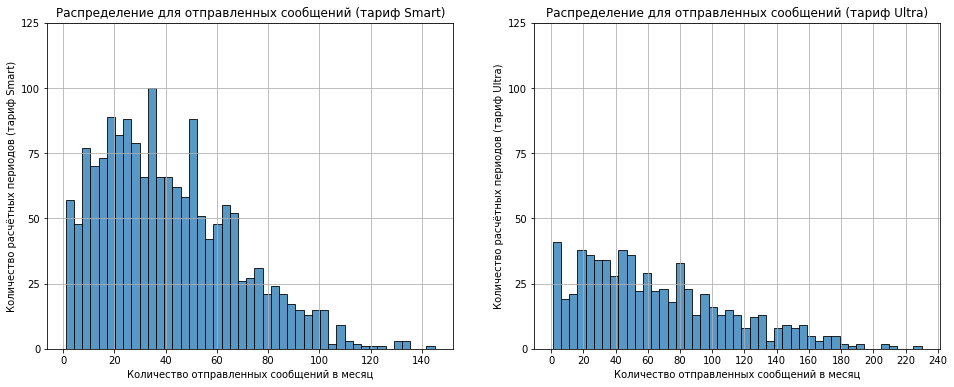

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(data=smart_messages[smart_messages > 0], bins=45, ax=ax[0])
sns.histplot(data=ultra_messages[ultra_messages > 0], bins=45, ax=ax[1])
_ = ax[0].set_title('Распределение для отправленных сообщений (тариф Smart)')
_ = ax[1].set_title('Распределение для отправленных сообщений (тариф Ultra)')
_ = ax[0].set_xticks(range(0, 150, 20))
_ = ax[1].set_xticks(range(0, 250, 20))
_ = ax[0].set_yticks(range(0, 150, 25))
_ = ax[1].set_yticks(range(0, 150, 25))
_ = ax[0].set_xlabel('Количество отправленных сообщений в месяц')
_ = ax[1].set_xlabel('Количество отправленных сообщений в месяц')
_ = ax[0].set_ylabel('Количество расчётных периодов (тариф Smart)')
_ = ax[1].set_ylabel('Количество расчётных периодов (тариф Ultra)')
_ = ax[0].grid()
_ = ax[1].grid()

В целом распределения для обоих тарифов выглядят похожим образом: они сравнительно быстро растут и имеют довольно длинный правый хвост, который явно длиннее для тарифа "_Ultra_".

Теперь посмотрим на гистограммы суммарных минут звонков по расчётным периодам (полным месяцам):

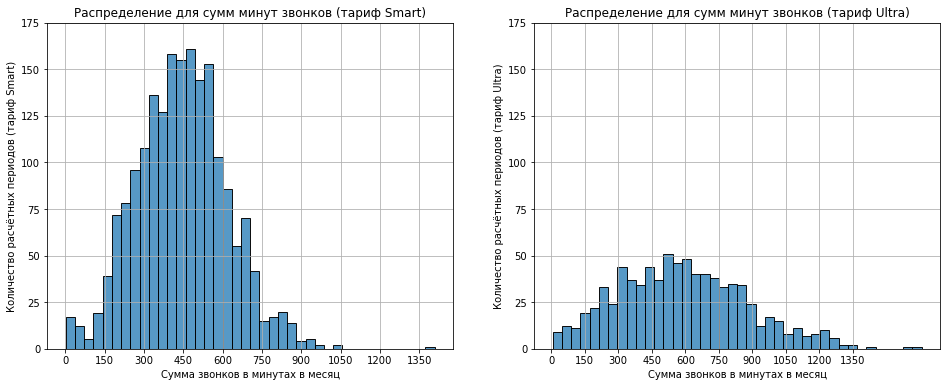

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(data=smart_calls[smart_calls > 0], bins=40, ax=ax[0])
sns.histplot(data=ultra_calls[ultra_calls > 0], bins=40, ax=ax[1])
_ = ax[0].set_title('Распределение для сумм минут звонков (тариф Smart)')
_ = ax[1].set_title('Распределение для сумм минут звонков (тариф Ultra)')
_ = ax[0].set_xticks(range(0, 1500, 150))
_ = ax[1].set_xticks(range(0, 1500, 150))
_ = ax[0].set_yticks(range(0, 200, 25))
_ = ax[1].set_yticks(range(0, 200, 25))
_ = ax[0].set_xlabel('Сумма звонков в минутах в месяц')
_ = ax[1].set_xlabel('Сумма звонков в минутах в месяц')
_ = ax[0].set_ylabel('Количество расчётных периодов (тариф Smart)')
_ = ax[1].set_ylabel('Количество расчётных периодов (тариф Ultra)')
_ = ax[0].grid()
_ = ax[1].grid()

Данные распределения уже похожи на нормальное. Видно, что гистограмма для тарифа "_Ultra_" выглядит более широкой, что данные этого распределения имеют большее стандартное отклонение `341.613 мин.`, чем данные распределения "_Smart_" - там стандартное отклонение равно `221.328 мин.`

Наконец, построим гистограммы для распределений интернет-трафика:

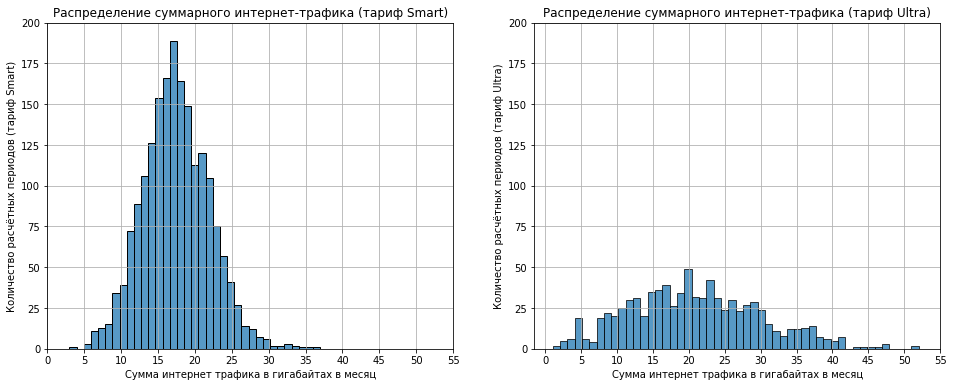

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(data=smart_internet[smart_internet > 0], bins=35, ax=ax[0])
sns.histplot(data=ultra_internet[ultra_internet > 0], bins=50, ax=ax[1])
_ = ax[0].set_title('Распределение суммарного интернет-трафика (тариф Smart)')
_ = ax[1].set_title('Распределение суммарного интернет-трафика (тариф Ultra)')
_ = ax[0].set_xticks(range(0, 60, 5))
_ = ax[1].set_xticks(range(0, 60, 5))
_ = ax[0].set_yticks(range(0, 225, 25))
_ = ax[1].set_yticks(range(0, 225, 25))
_ = ax[0].set_xlabel('Сумма интернет трафика в гигабайтах в месяц')
_ = ax[1].set_xlabel('Сумма интернет трафика в гигабайтах в месяц')
_ = ax[0].set_ylabel('Количество расчётных периодов (тариф Smart)')
_ = ax[1].set_ylabel('Количество расчётных периодов (тариф Ultra)')
_ = ax[0].grid()
_ = ax[1].grid()

Гистограмма для тарифа "_Smart_" слева выглядит почти идеальной кривой нормального распределения, лишь с очень маленьким правым хвостиком.

Гистограмма для тарифа "_Ultra_" напоминает нормальную лишь очень приближённо: разброс (разнообразие) там всё же больше при меньшем количестве расчётных периодов (меньшей общей площадью под графиком).

### Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение `alpha` задайте самостоятельно.

Поясните:

- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

---------------

Для начала создадим распределения для доходов (на этот раз рассматривая все месяцы, в том числе и неполные, т.е. используя `all_proceeds`, а не `fm_proceeds`) по тарифным планам, формируя наборы `smart_proceeds` и `ultra_proceeds`. Здесь маску не используем - все периоды, когда пользователь являлся абонентом, уже будут иметь положительное значение из-за абонентской платы:

In [144]:
def convert_proceeds_to_distributions(proceeds, collection1, collection2):
    """Создаёт распределения выручек (proceeds) на основании идентификаторов пользователей, содержащихся в
    наборах collection1 и collection2"""
    proceeds1 = proceeds.query(f'user_id in @collection1')
    proceeds2 = proceeds.query(f'user_id in @collection2')
    proceeds1 = proceeds1.unstack().reset_index(drop=True)
    proceeds2 = proceeds2.unstack().reset_index(drop=True)
    return proceeds1[proceeds1 > 0], proceeds2[proceeds2 > 0]

smart_proceeds, ultra_proceeds = convert_proceeds_to_distributions(all_proceeds, smart_users, ultra_users)

display(smart_proceeds.to_frame())
display(ultra_proceeds.to_frame())

,0
2,607
22,2550
34,962
40,1372
53,1550
...,...
4511,550
4516,550
4519,550
4546,550


,0
32,1950
35,1950
46,1950
65,1950
109,1950
...,...
1885,1950
1893,1950
1897,1950
1917,1950


Сделаем то же самое для создания наборов для распределений расчётных периодов (вновь всех, а не только полных месяцев) для Москвы и прочих городов: `msk_proceeds` и `nonmsk_proceeds`:

In [145]:
msk_users    = users.query('city == "Москва"')['user_id']
nonmsk_users = users.query('city != "Москва"')['user_id']

msk_proceeds, nonmsk_proceeds = convert_proceeds_to_distributions(all_proceeds, msk_users, nonmsk_users)

display(msk_proceeds.sort_values().to_frame())
display(nonmsk_proceeds.sort_values().to_frame())

,0
1286,550
992,550
1016,550
1023,550
1028,550
...,...
671,3600
1029,3622
948,4050
369,4200


,0
5194,550
3788,550
3791,550
3801,550
1661,550
...,...
4222,5131
2212,5250
2603,5250
3997,5797


Посмотрим на характеристики распределений средней выручки по тарифам в единой совместной таблице:

In [146]:
pd.options.display.float_format = '{:.3f}'.format

proceeds_describe = pd.DataFrame({'smart': smart_proceeds.describe(), 'ultra': ultra_proceeds.describe()})
proceeds_describe.loc['var', 'smart'] = smart_proceeds.var()
proceeds_describe.loc['var', 'ultra'] = ultra_proceeds.var()
display(proceeds_describe)

,smart,ultra
count,2268.000,996.000
mean,1243.609,2063.253
std,777.428,377.928
min,550.000,1950.000
25%,550.000,1950.000
50%,960.500,1950.000
75%,1702.000,1950.000
max,6456.000,5250.000
var,604393.568,142829.206


Видно, что средние значения выручки различаются довольно существенно - `1243 ₽` для тарифа "_Smart_" и `2063 ₽` для тарифа "_Ultra_".

Теперь проверим нашу первую гипотезу о том, что "_средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются_".

Поскольку мы не можем судить о среднем значении выручки всех пользователей данных двух тарифов, а вынуждены делать оценку на основании имеющейся выборки из `500` абонентов, требуется статистическая проверка гипотезы о равенстве средних наших двух генеральных совокупностей (всех пользователей тарифа "_Smart_" и всех пользователей тарифа "_Ultra_") на основе выборок из них.

Считаем, что нулевая гипотеза $H_0$ гласит, что средние двух совокупностей равны между собой, или что разность между ними равна `0`. Тогда альтернативная гипотеза $H_1$ утверждает, что разница между средними не равна `0` (и использование этого "_не равна_" означает, что мы будем рассматривать двустороннюю гипотезу $H_1$).

Для проверки равенства средних двух генеральных совокупностей будем использовать метод `scipy.stats.ttest_ind()`, поскольку мы имеем дело с независимыми выборками, а не с одной и той же выборкой (т.е. с одними и теми же абонентами) до и после какого-либо изменения, их затрагивающего.

Далее нам необходимо принять решение о параметре `equal_var` - выставить ему значение `True` или `False`. Поскольку выборки у нас разного размера (это можно видеть в выведенном датафрейме выше), и, кажется, нет оснований полагать, что у них будет одинаковая дисперсия, укажем значением данного параметра `False`:

```python
equal_var=False
```

Судя по описанию метода `scipy.stats.ttest_ind()`, это приведёт к тому, что дисперсии будут подсчитаны на каждой из выборок отдельно. Но обе выборки у нас достаточно большого размера, что, надо полагать, позволит оценить дисперсии генеральных совокупностей более-менее корректно.

Итак, оцениваем значение `p-value` описанным выше способом:

In [147]:
smart_vs_ultra_result = st.ttest_ind(smart_proceeds, ultra_proceeds, equal_var=False)
print(f"p-value = {smart_vs_ultra_result.pvalue}")

p-value = 3.207595384114566e-290


Можно видеть, что полученное значение `p-value` крайне мало. Мало настолько, что даже нет смысла рассматривать какой-то критический уровень статистической значимости `alpha`, поскольку он всё равно будет больше того `p-value`, которое мы получили.

Столь малое значение `p-value` говорит о том, что вероятность получить такое или большее различие при условии, что гипотеза $H_0$ верна, исчезающе мала. То есть мы **отвергаем нулевую гипотезу $H_0$** в пользу альтернативной: средняя выручка пользователей тарифов "_Smart_" и "_Ultra_" действительно различаются (между средними значениями выручек наших тарифных планов есть статистически значимая разница).

---------

Прежде чем переходить к проверке второй гипотезы, как и прежде посмотрим на характеристики распределений средней выручки по Москве и прочим городам в единой совместной таблице:

In [148]:
msk_nonmsk_describe = pd.DataFrame({'MSK': msk_proceeds.describe(), 'NON-MSK': nonmsk_proceeds.describe()})
msk_nonmsk_describe.loc['var', 'MSK'] = msk_proceeds.var()
msk_nonmsk_describe.loc['var', 'NON-MSK'] = nonmsk_proceeds.var()
display(msk_nonmsk_describe)

,MSK,NON-MSK
count,621.000,2643.000
mean,1511.950,1489.438
std,719.985,791.603
min,550.000,550.000
25%,772.000,721.000
50%,1717.000,1550.000
75%,1950.000,1950.000
max,4610.000,6456.000
var,518378.154,626636.020


Видно, что средние значения выручки в этом случае весьма близки между собой - `1511 ₽` для Москвы и `1489 ₽` для прочих городов.

Теперь проверим вторую гипотезу о том, что "_средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов_".

Проверка данной гипотезы будет во многом аналогична проверке прошлой гипотезы. Вновь считаем, что нулевая гипотеза $H_0$ гласит, что средние двух совокупностей равны между собой. Альтернативная гипотеза $H_1$ утверждает, что разница между средними не равна `0`.

Для проверки равенства средних двух генеральных совокупностей снова будем применять метод `scipy.stats.ttest_ind()`, и в качестве значения параметра `equal_var` вновь будем использовать `False`:

In [149]:
msk_vs_nonmsk_result = st.ttest_ind(msk_proceeds, nonmsk_proceeds, equal_var=False)
print(f"p-value = {msk_vs_nonmsk_result.pvalue}")

p-value = 0.4918443163751536


Полученное значение `p-value` говорит о том, что вероятность получить такое или большее различие случайно почти `50%`. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними значениями выручек при любом значении критического уровня значимости `alpha`. Таким образом, мы **не можем отвергнуть нулевую гипотезу $H_0$** (у нас нет для этого достаточно доказательств), и, соответственно, не можем говорить, что между выручками абонентов из Москвы и из других регионов есть разница.

### Шаг 5. Напишите общий вывод

Исследование прибыльности тарифных планов "_Smart_" и "_Ultra_" было проведено на основании выборки из `500` абонентов. Средние значения выручки для выборок по каждому из тарифов продемонстрировали довольно заметную разницу между собой:

- "_Smart_": `1243 ₽`


- "_Ultra_": `2063 ₽`

Кроме того, статистическая проверка гипотезы о равенстве средних генеральных совокупностей абонентов тарифа "_Smart_" и "_Ultra_" подтвердила необоснованность предположения о равенстве средних значений выручки для данных тарифов: нельзя утверждать, что абоненты тарифа "_Smart_" приносят ту же выручку, что и абоненты тарифа "_Ultra_". 

Хотя была проверена двусторонняя гипотеза, глядя на средние значения на выборках, можно заметить, что тариф "_Ultra_" приносит больше прибыли для компании.

В то же время здесь стоит также сделать замечание о том, что выборочное среднее значение для тарифа "_Ultra_" лишь незначительно превышает размер абонентской платы (`1950 ₽`) - есть опасения, что при снижении абонентской платы снизится и выручка, поскольку абоненты данного тарифного плана в среднем вновь будут приносить выручку, лишь незначительно превышающую абонентскую плату.

Наконец, была рассмотрена гипотеза о равенстве средних значений выручки для абонентов из Москвы (выборочное среднее `1511 ₽`) и других регионов (выборочное среднее `1489 ₽`): в ходе статистической проверки не было получено доказательств того, что данные средние значения для генеральных совокупностей различаются между собой.